# German Credit Risk Case Study
#### C. Griffith - BUSI 650 Summer 2022

##### **Objective** 

> To help a bank make a decision on whether to approve a loan to a prospective applicant based on their financial, demographic and socio-economic profiles

## ***Import packages and define functions.***

In [ ]:
# import packages
#from google.colab import drive <--- moved computation to local machine
import copy

# Library to suppress warnings or deprecation notes
import warnings

# To perform statistical analysis
from itertools import combinations
from scipy.stats import ttest_ind
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from math import log2, sqrt

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm.notebook import tqdm

# To build models
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Library to split data
from sklearn.model_selection import train_test_split

# for plotting calibration curve using true and predicted labels.
from sklearn.calibration import CalibrationDisplay

# To tune different models
# https://www.vantage-ai.com/en/blog/bayesian-optimization-for-quicker-hyperparameter-tuning
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold

# To get diferent metric scores
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix, 
    ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_recall_curve, roc_auc_score,
    PrecisionRecallDisplay, average_precision_score, auc, f1_score, recall_score, precision_score,
    plot_confusion_matrix, make_scorer, 
)

# matplotlib graphs will be included in notebook, next to the code
%matplotlib inline 

# format for seaborn plots
sns.set(color_codes=True)
sns.set(style="darkgrid")

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# ignore warnings
warnings.filterwarnings("ignore")

In [ ]:
# function to plot stacked bar chart.
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    #tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(by=sorter, ascending=False)
    #print(tab1)
    #print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [ ]:
# function to create box plot and histplot on same axis
def HistBoxPlot(dataframe, feature, hue = None, cum = False, bins = 'auto'):
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = (9,7)) 
                                          
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='yellow'); # A star will indicate the mean value of the column
    sns.histplot(data=dataframe, x=feature, kde=True, hue=hue, bins=bins, cumulative = cum, ax=ax_hist2); # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='-'); # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-'); # Add median to the histogram

In [ ]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification(model, predictors, target):

    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [ ]:
def make_confusion_matrix(model, predictors, target):

    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, fmt="", cmap="Blues")

## ***Read the dataset into pandas dataframes.***

In [ ]:
# Authorization of GDrive
#drive.mount('/content/drive/') <--- moved computation to local machine

# Change working directory location to datasets
#%cd /content/drive/MyDrive/Data_Science/BUSI_650_Business_Analytics_Decision_Making/Data_Sets
%cd /Users/christophergriffith/Desktop/

# Load dataset
data = pd.read_csv('German_Credit.csv')

df = data.copy()

## ***Explore***
* Examined the data set and carried out EDA 

**Attribute Information:**
The data contains characteristics of the people
* **Age** (Numeric: Age in years)
* **Sex** (Categories: male, female)
* **Job** (Categories : unskilled and non-resident,  unskilled and resident, skilled, highly skilled)
* **Housing** (Categories: own, rent, or free)
* **Saving accounts** (Categories: little, moderate, quite rich, rich)
* **Checking account** (Categories: little, moderate, rich)
* **Credit amount** (Numeric: Amount of credit in DM - Deutsche Mark)
* **Duration** (Numeric: Duration for which the credit is given in months)
* **Purpose** (Categories: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)
* **Risk** (0 - Person is not at risk, 1 - Person is at risk(defaulter))


### ***Initial Review***

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   object
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Risk              1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [ ]:
# rename columns that have spaces
df.rename(columns={
    "Saving accounts": "Saving_Accounts",
    "Checking account": "Checking_Account",
    "Credit amount": "Credit_Amount",
    }, inplace=True,
)

In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1000,NaN,NaN,NaN,35.546,11.3755,19,27,33,42,75
Sex,1000,2,male,690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Job,1000,3,skilled,630,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Housing,1000,3,own,713,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saving_Accounts,1000,4,little,786,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Checking_Account,1000,3,moderate,472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit_Amount,1000,NaN,NaN,NaN,3271.26,2822.74,250,1365.5,2319.5,3972.25,18424
Duration,1000,NaN,NaN,NaN,20.903,12.0588,4,12,18,24,72
Risk,1000,NaN,NaN,NaN,0.3,0.458487,0,0,0,1,1
Purpose,1000,8,car,337,NaN,NaN,NaN,NaN,NaN,NaN,NaN



**Observation**

> There are 1000 records, nine features and one target variable. Six out of nine features are categorical.


---



### ***Univariate analysis***

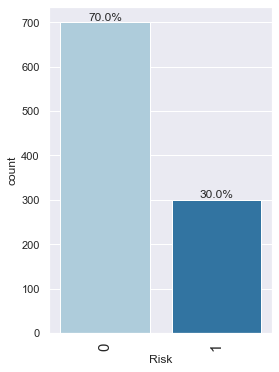

In [ ]:
labeled_barplot(df, "Risk", perc=True)


**Observation**

> The likelihood a random prospective applicant is *NOT* a risk is 70%. The class labels are unbalanced.


---

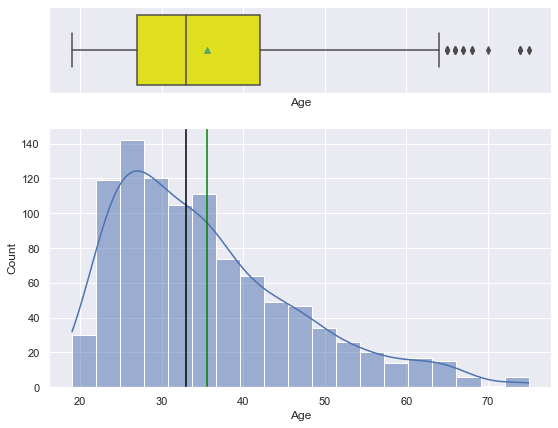

In [ ]:
HistBoxPlot(df, df.Age);


**Observation**

> The median age is around 34 while the mean is around 35. The age distribution is skewed to the right. Theere are a few outliers accounting for older aged applicants.


---

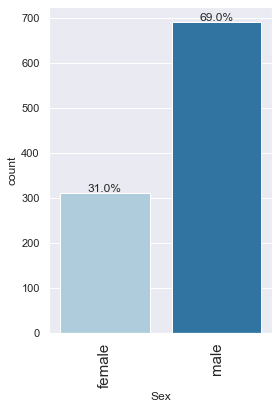

In [ ]:
labeled_barplot(df, "Sex", perc=True)

**Observation**

> There are more males (69%) than females (31%) accounted for in the dataset.


---

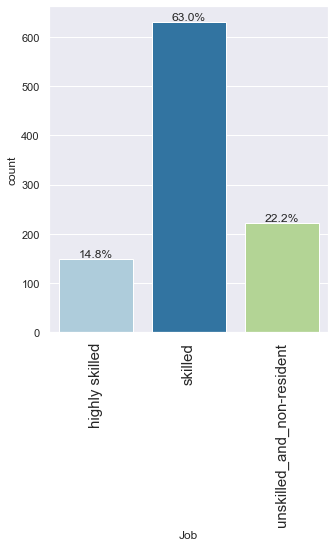

In [ ]:
labeled_barplot(df, "Job", perc=True)

**Observation**

> Applicants tend to have skilled jobs compared to highly skilled and unskilled/non-resident.


---

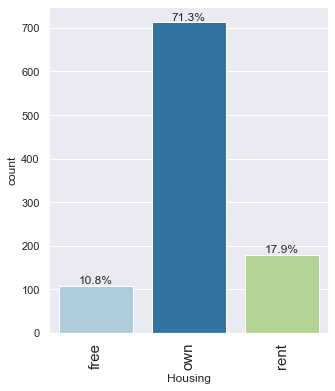

In [ ]:
labeled_barplot(df, "Housing", perc=True)

**Observation**

> About 71% of applicants own their home compared to 18% renting and 11% living rent or mortgage free.


---

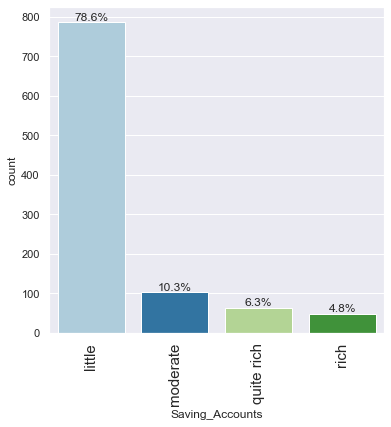

In [ ]:
labeled_barplot(df, "Saving_Accounts", perc=True)

**Observation**

> Applicants are more likely to have "little" amounts of money in their Savings Accounts.


---

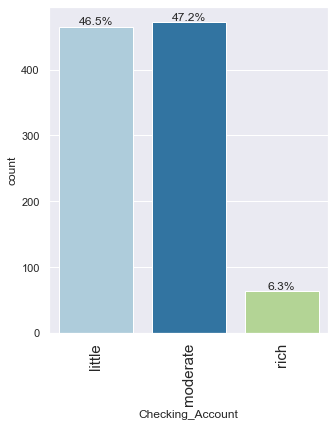

In [ ]:
labeled_barplot(df, "Checking_Account", perc=True)

**Observation**

> Applicants are about equally likely to have little or moderate amounts of money in their Checking Accounts.


---

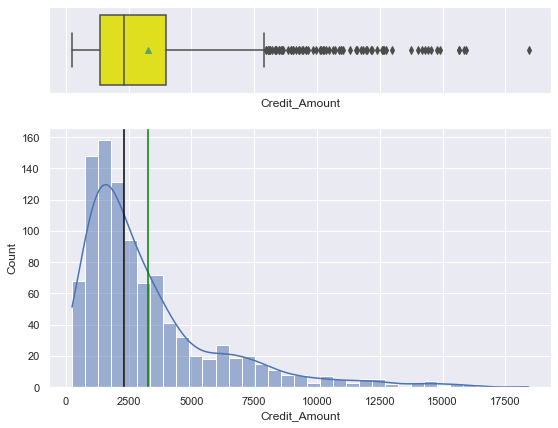

In [ ]:
HistBoxPlot(df, df.Credit_Amount);

**Observation**

> The median prospective credit amount is around 2000 while the mean is around 3000. The credit amount distribution is skewed to the right. There are numerous outliers accounting for credit amounts greater than 8000.


---

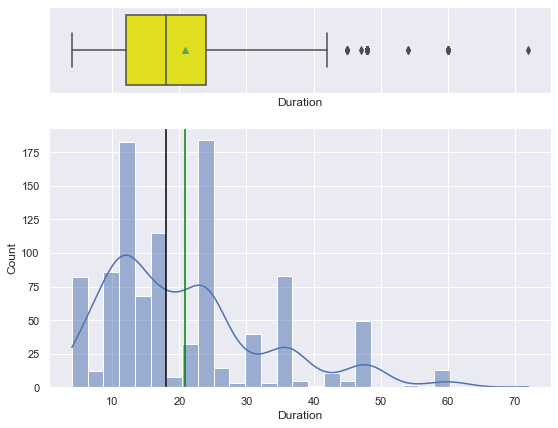

In [ ]:
HistBoxPlot(df, df.Duration);

**Observation**

> The median duration of applicants' prospective loans is around 18 months while the mean is around 22 months. There are a few outliers accounting for durations greater than 42 months.


---

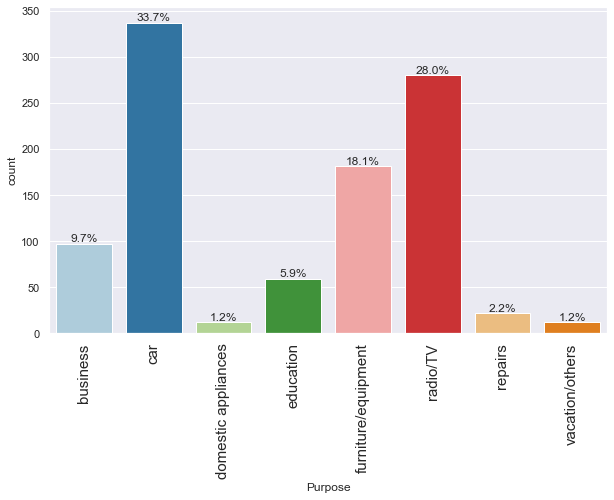

In [ ]:
labeled_barplot(df, "Purpose", perc=True)

**Observation**

> Applicants are more likely to want a loan for a car, radio/tv or furniture/equipment.


---

### ***Bivariate Analysis - Part 1***

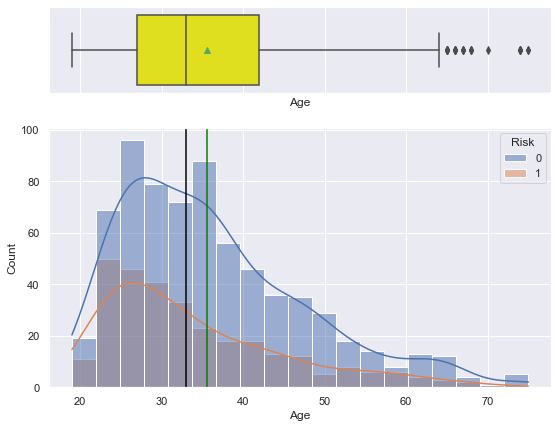

In [ ]:
HistBoxPlot(df, df.Age, df.Risk);

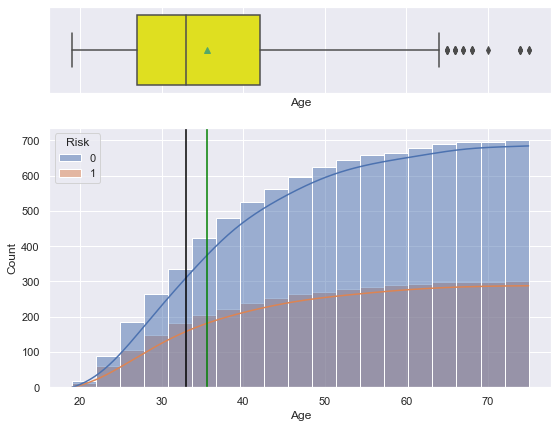

In [ ]:
HistBoxPlot(df, df.Age, df.Risk, True);

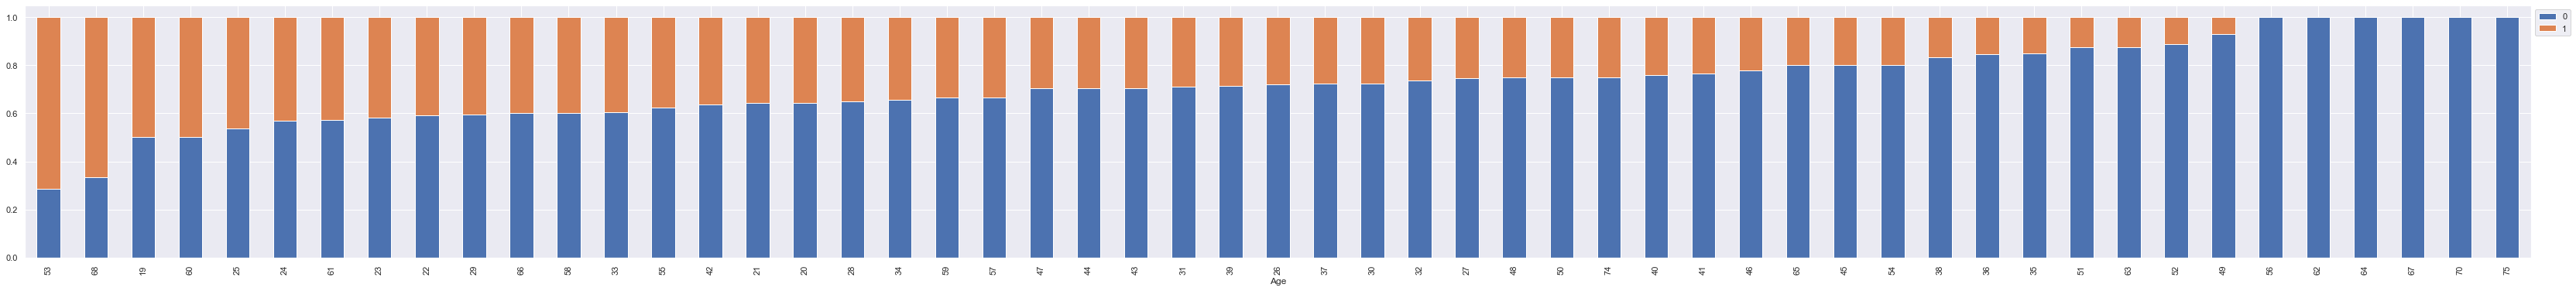

In [ ]:
stacked_barplot(df, "Age", "Risk")


**Observation**

> It appears that certain age brackets (early/mid 20s and mid/late 50s) are at higher risk to default on their loans.


---

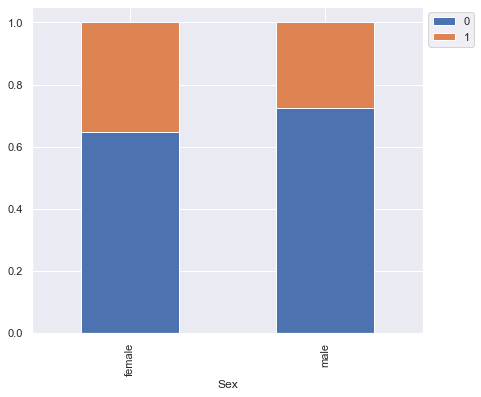

In [ ]:
stacked_barplot(df, "Sex", "Risk")


**Observation**

> Females are slightly higher than males to default on their loans.


---

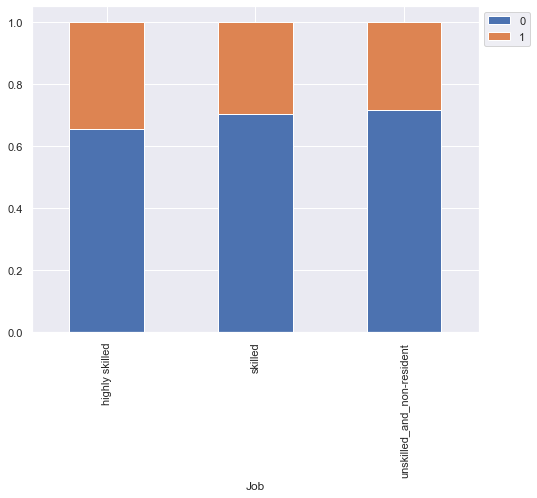

In [ ]:
stacked_barplot(df, "Job", "Risk")


**Observation**

> Applicants with highly skilled jobs are most likely to default on loans. Skilled and unskileed/non-resident applicants are about equal in their likelihood to default on loans.


---

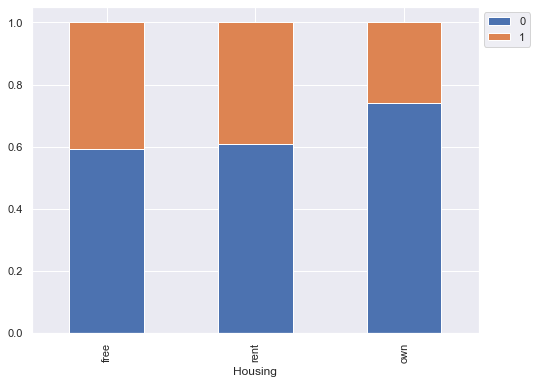

In [ ]:
stacked_barplot(df, "Housing", "Risk")


**Observation**

> Applicants who own their home are least likely default on their loan. Renters are those who do not pay for housing are equally likely to default on their loan.


---

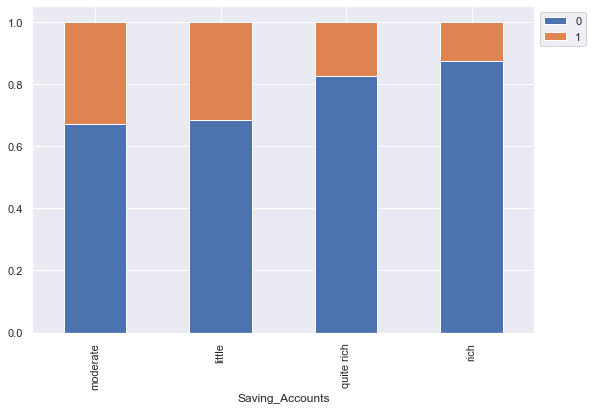

In [ ]:
stacked_barplot(df, "Saving_Accounts", "Risk")


**Observation**

> Applicants with saving accounts considered rich or quite rich are least likely to default on a loan while moderate and little saving accounts have a higher chance of defaulting on loans.


---

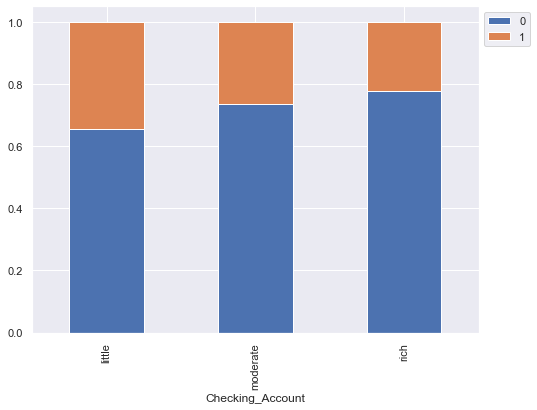

In [ ]:
stacked_barplot(df, "Checking_Account", "Risk")


**Observation**

> Applicants with checking accounts considered little are most likely to default on their loan.


---

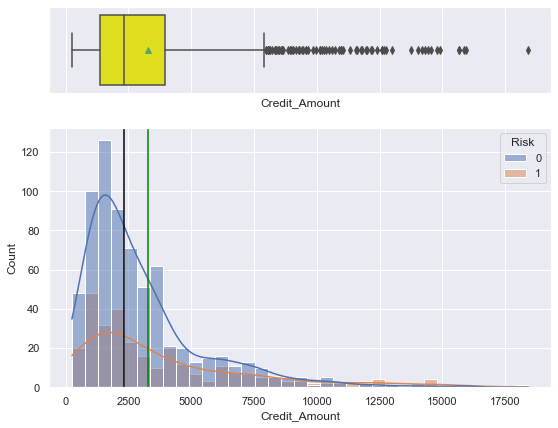

In [ ]:
HistBoxPlot(df, df['Credit_Amount'], df.Risk);

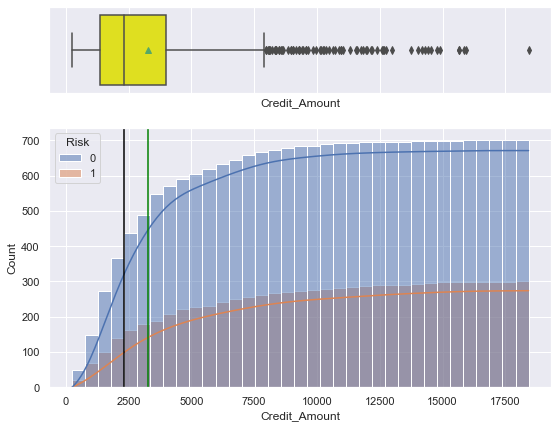

In [ ]:
HistBoxPlot(df, df['Credit_Amount'], df.Risk, True);


**Observation**

> It appears that certain credit ammounts (mid 4000, low 7000 and a mixture of higher amounts over 8000) are at higher risk to default on their loans.


---

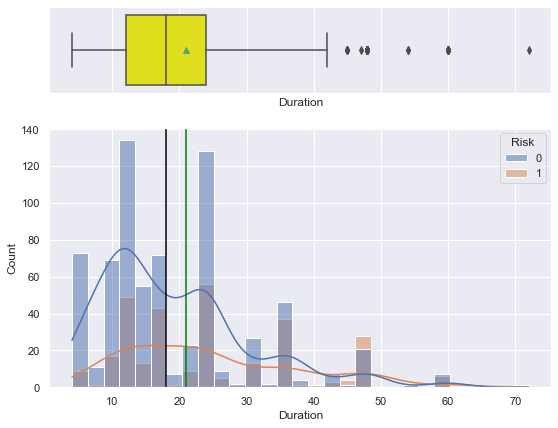

In [ ]:
HistBoxPlot(df, df['Duration'], df.Risk);

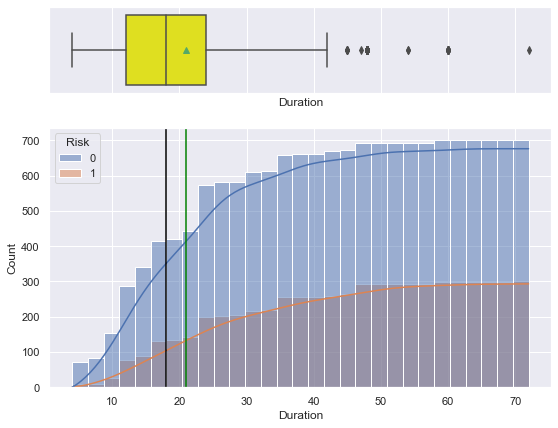

In [ ]:
HistBoxPlot(df, df['Duration'], df.Risk, True);

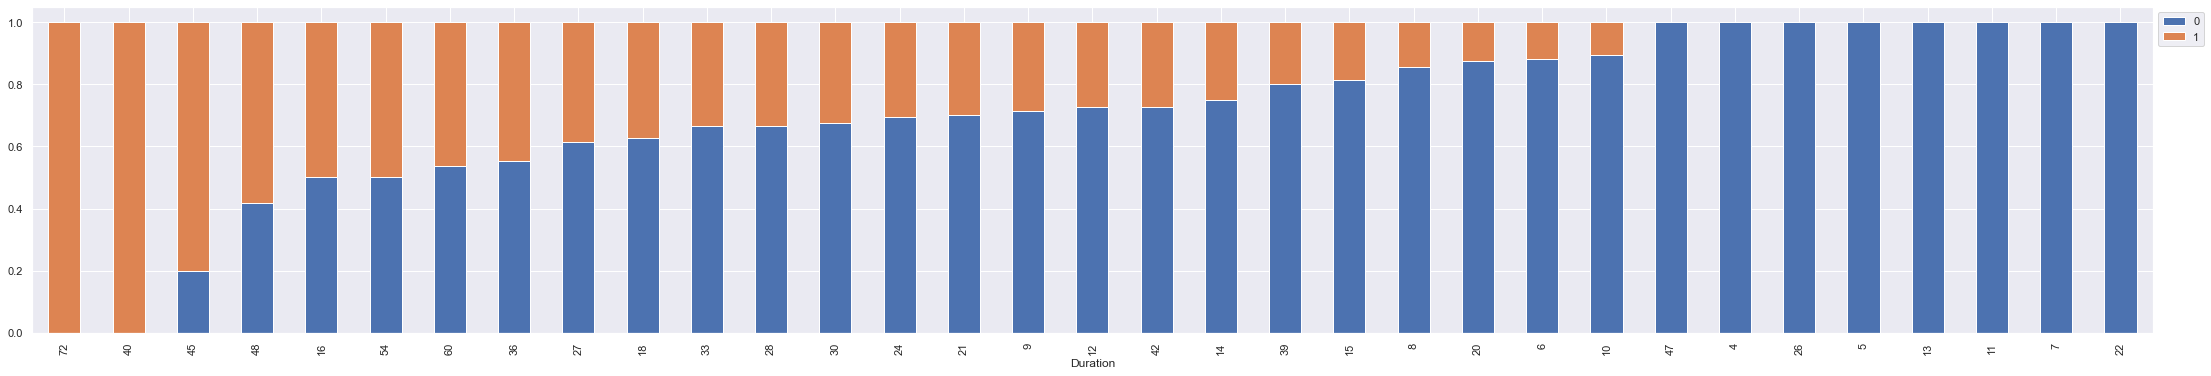

In [ ]:
stacked_barplot(df, "Duration", "Risk")


**Observation**

> Duration and Risk relationship is not as clear. 72, 40, 45 and 48 are the most likely durations that end up with defaulted loans.


---

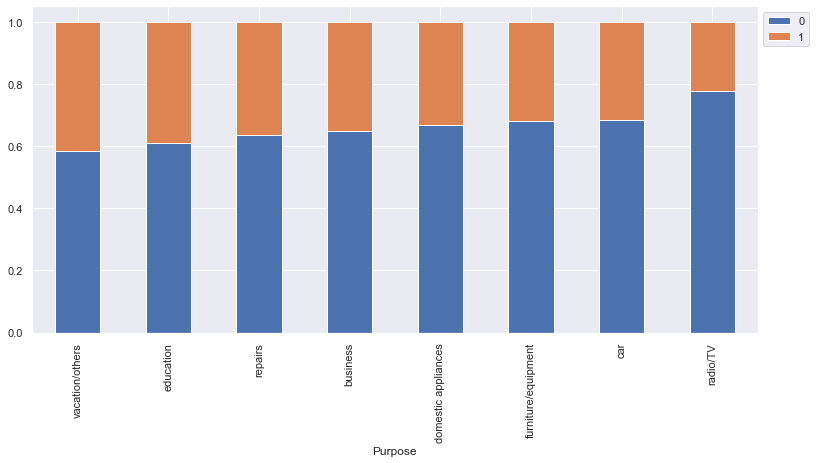

In [ ]:
stacked_barplot(df, "Purpose", "Risk")


**Observation**

> Applicants who apply for a loan for vacation/other and eduation are the most at risk to default. Most of the purpose categories has very similar risk likelihoods.


---

### ***Bivariate Analysis - Part 2***

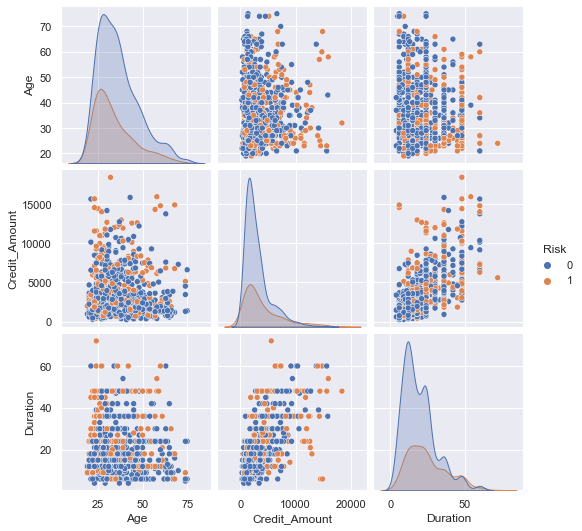

In [ ]:
sns.pairplot(df, hue='Risk');

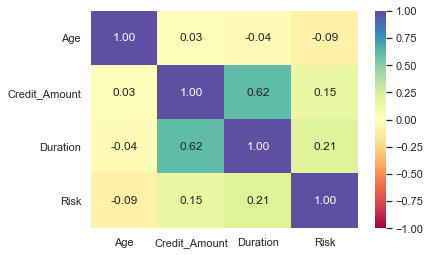

In [ ]:
# Studying correlation among numeric variables
sns.heatmap(df[['Age', 'Credit_Amount', 'Duration', 'Risk']].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral");


**Observation**

> Credit Amount and Duration appear to have a strong positive correlation. 

---

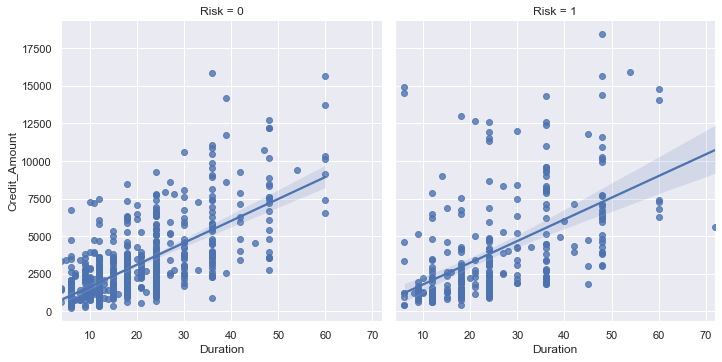

In [ ]:
sns.lmplot(x="Duration", y="Credit_Amount", col="Risk", data=df);


**Observation**

> For applicants who are considered risky and non-risky, it appears that as the duration of a loan increases so does the a credit amount. However, non-risky applicants seem to be more clustered toward lower durations and lower credit amounts.


---

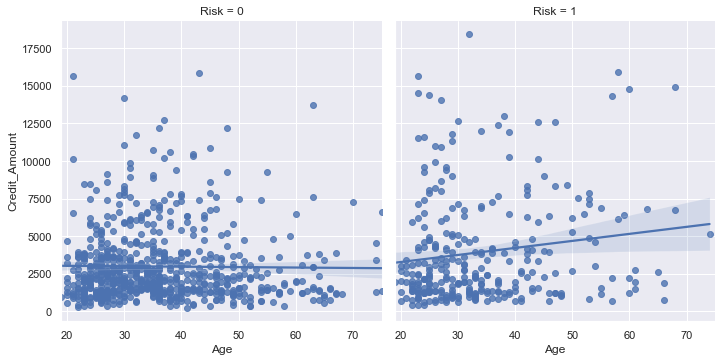

In [ ]:
sns.lmplot(x="Age", y="Credit_Amount", col="Risk", data=df);


**Observation**

> For applicants who are considered risky and non-risky, it appears that as the age of the applicant increases so does the a credit amount. However, non-risky applicants seem to be more clustered towards lower ages and lower credit amounts.


---

### ***Bivariate Analysis - Part 3***

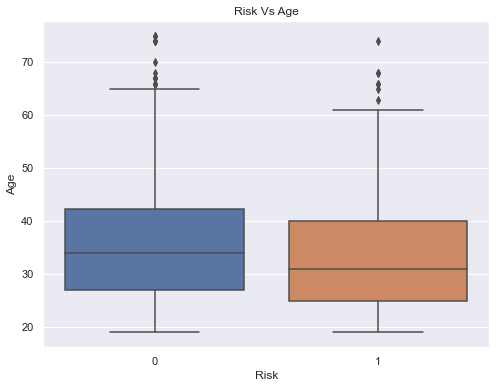

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="Risk", y="Age", data=df).set(title="Risk Vs Age");


**Observation**

> Applicants who are classified as risky appear to have a median age lower than those who are not risky. The range of the ages seems to be smaller for risky applicants compared to non-risky applicants.

---

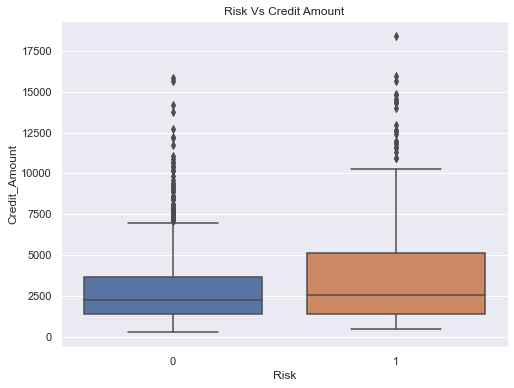

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="Risk", y="Credit_Amount", data=df).set(title="Risk Vs Credit Amount");


**Observation**

> Applicants who are classified as risky appear to have a median a credit amount higher than those who are not risky. The range of the credit ammounts seems to be larger for risky applicants compared to non-risky applicants.

---

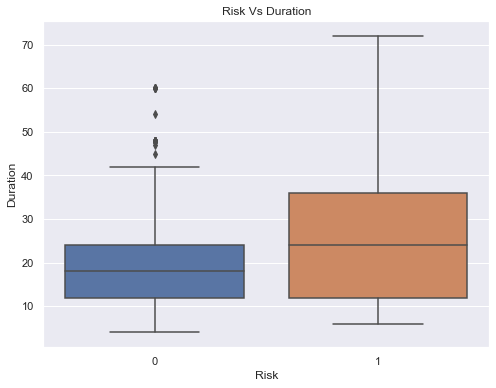

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="Risk", y="Duration", data=df).set(title="Risk Vs Duration");


**Observation**

> Applicants who are classified as risky appear to have a median duration higher than those who are not risky. The range of the durations seems to be larger for risky applicants compared to non-risky applicants.

---

### ***Statistical Significant Between Key Features***

#### ***Categorical Data:*** *Sex, Job, Housing, Saving_Accounts, Checking_Account, and Purpose*

In [ ]:
#identify categorical features
df_categorical = df[['Sex', 'Job', 'Housing', 'Saving_Accounts', 'Checking_Account', 'Purpose', 'Risk']] 
categoritcal_features =  df_categorical.columns.values
comb = list(combinations(categoritcal_features, 2))

In [ ]:
for features in comb:

  # Contingency table of Purpose and Housing attributes
  crosstab = pd.crosstab(df[features[0]], df[features[1]])  

  Ho = "{} has NO effect on {} score".format(features[0], features[1])  # Stating the Null Hypothesis
  Ha = "{} has an effect on {} score".format(features[0], features[1])   # Stating the Alternate Hypothesis

  chi, p_value, dof, expected = stats.chi2_contingency(crosstab)

  if p_value < 0.05:  # Setting our significance level at 5%
      print(f"-----> {Ha} as the p_value ({p_value.round(3)}) < 0.05\n")
  else:
      print(f"{Ho} as the p_value ({p_value.round(3)}) > 0.05\n")
  

Sex has NO effect on Job score as the p_value (0.165) > 0.05

-----> Sex has an effect on Housing score as the p_value (0.0) < 0.05

Sex has NO effect on Saving_Accounts score as the p_value (0.461) > 0.05

Sex has NO effect on Checking_Account score as the p_value (0.766) > 0.05

-----> Sex has an effect on Purpose score as the p_value (0.003) < 0.05

-----> Sex has an effect on Risk score as the p_value (0.021) < 0.05

-----> Job has an effect on Housing score as the p_value (0.0) < 0.05

Job has NO effect on Saving_Accounts score as the p_value (0.417) > 0.05

Job has NO effect on Checking_Account score as the p_value (0.708) > 0.05

-----> Job has an effect on Purpose score as the p_value (0.0) < 0.05

Job has NO effect on Risk score as the p_value (0.417) > 0.05

Housing has NO effect on Saving_Accounts score as the p_value (0.719) > 0.05

Housing has NO effect on Checking_Account score as the p_value (0.684) > 0.05

-----> Housing has an effect on Purpose score as the p_value (0.


**Observation**

> Based on the Chi Square Test, there are a few categorical features that have a significant influence on one another.



---

#### ***Continuous Data:*** *Age, Credit_Amount, and Duration*

In [ ]:
feature_0 =  df[(df.Risk == 0)].Age
feature_1 =  df[(df.Risk == 1)].Age
mean_1 = feature_0.mean()
mean_2 = feature_1.mean()
std_1 = feature_0.std()
std_2 = feature_1.std()

# find the sample means and sample standard deviations for the two samples
print('The mean Age of those labeled no risk is ' + str(mean_1))
print('The mean Age of those labeled as risky is ' + str(mean_2))
print('The standard deviation of Age of those labeled no risk is ' + str(round(std_1,4)))
print('The standard deviation of Age of those labeled as risky is ' + str(round(std_2,4)))

# find the p-value
test_stat, p_value = ttest_ind(feature_0, feature_1, equal_var = True, alternative = 'greater')
print('\nThe p-value is', p_value)
print('Significant Difference between Means (u1 > u2) - Age may have an affect on Risk')

The mean Age of those labeled no risk is 36.22428571428571
The mean Age of those labeled as risky is 33.96333333333333
The standard deviation of Age of those labeled no risk is 11.3811
The standard deviation of Age of those labeled as risky is 11.2224

The p-value is 0.001962669699138141
Significant Difference between Means (u1 > u2) - Age may have an affect on Risk


**Observation**

> Based on the t-Test, there is a significant difference between the mean Ages of those who are risky and those who are not risky. There is significant evidence to suggest that the mean age of those who are NOT risky is higher than those who are not.



---

In [ ]:
feature_0 =  df[(df.Risk == 0)].Credit_Amount
feature_1 =  df[(df.Risk == 1)].Credit_Amount
mean_1 = feature_0.mean()
mean_2 = feature_1.mean()
std_1 = feature_0.std()
std_2 = feature_1.std()

# find the sample means and sample standard deviations for the two samples
print('The mean Credit_Amount of those labeled no risk is ' + str(mean_1))
print('The mean Credit_Amount of those labeled as risky is ' + str(mean_2))
print('The standard deviation of Credit_Amount of those labeled no risk is ' + str(round(std_1,4)))
print('The standard deviation of Credit_Amount of those labeled as risky is ' + str(round(std_2,4)))

# find the p-value
test_stat, p_value = ttest_ind(feature_0, feature_1, equal_var = False, alternative = 'less')
print('\nThe p-value is', p_value)
print('Significant Difference between Means (u1 < u2) - Credit_Amount may have an affect on Risk')

The mean Credit_Amount of those labeled no risk is 2985.457142857143
The mean Credit_Amount of those labeled as risky is 3938.1266666666666
The standard deviation of Credit_Amount of those labeled no risk is 2401.4723
The standard deviation of Credit_Amount of those labeled as risky is 3535.819

The p-value is 1.2388566675241325e-05
Significant Difference between Means (u1 < u2) - Credit_Amount may have an affect on Risk


**Observation**

> Based on the t-Test, there is a significant difference between the mean credit amounts of those who are risky and those who are not risky. There is significant evidence to suggest that the mean credit amounts of those who are NOT risky is lower than those who are not.



---

In [ ]:
feature_0 =  df[(df.Risk == 0)].Duration
feature_1 =  df[(df.Risk == 1)].Duration
mean_1 = feature_0.mean()
mean_2 = feature_1.mean()
std_1 = feature_0.std()
std_2 = feature_1.std()

# find the sample means and sample standard deviations for the two samples
print('The mean duration of those labeled no risk is ' + str(mean_1))
print('The mean duration of those labeled as risky is ' + str(mean_2))
print('The standard deviation of duration of those labeled no risk is ' + str(round(std_1,4)))
print('The standard deviation of duration of those labeled as risky is ' + str(round(std_2,4)))

# find the p-value
test_stat, p_value = ttest_ind(feature_0, feature_1, equal_var = False, alternative = 'less')
print('\nThe p-value is', p_value)
print('Significant Difference between Means (u1 < u2) - Duration may have an affect on Risk')

The mean duration of those labeled no risk is 19.207142857142856
The mean duration of those labeled as risky is 24.86
The standard deviation of duration of those labeled no risk is 11.0796
The standard deviation of duration of those labeled as risky is 13.2826

The p-value is 1.2020404299290382e-10
Significant Difference between Means (u1 < u2) - Duration may have an affect on Risk


**Observation**

> Based on the t-Test, there is a significant difference between the mean duration of those who are risky and those who are not risky. There is significant evidence to suggest that the mean duration of those who are NOT risky is lower than those who are not.



---

## ***Data Preparation***
* Checked for missing values
* Converted string (object) variables to category
* Created dummy variables

In [ ]:
# show number of null values in each column
df.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving_Accounts     0
Checking_Account    0
Credit_Amount       0
Duration            0
Risk                0
Purpose             0
dtype: int64

**Observation**

> None of the features have null values.



---

In [ ]:
df.dtypes

Age                  int64
Sex                 object
Job                 object
Housing             object
Saving_Accounts     object
Checking_Account    object
Credit_Amount        int64
Duration             int64
Risk                 int64
Purpose             object
dtype: object

In [ ]:
for column in df.columns.values:
  if df[column].dtypes == 'object':
    df[column] = df[column].astype('category')

In [ ]:
df.dtypes

Age                    int64
Sex                 category
Job                 category
Housing             category
Saving_Accounts     category
Checking_Account    category
Credit_Amount          int64
Duration               int64
Risk                   int64
Purpose             category
dtype: object

**Observation**

> The categorical features are properly converted to the categorical data type.



---

In [ ]:
df_w_dummies = pd.get_dummies(df, drop_first=True)

In [ ]:
df_w_dummies.dtypes

Age                               int64
Credit_Amount                     int64
Duration                          int64
Risk                              int64
Sex_male                          uint8
Job_skilled                       uint8
Job_unskilled_and_non-resident    uint8
Housing_own                       uint8
Housing_rent                      uint8
Saving_Accounts_moderate          uint8
Saving_Accounts_quite rich        uint8
Saving_Accounts_rich              uint8
Checking_Account_moderate         uint8
Checking_Account_rich             uint8
Purpose_car                       uint8
Purpose_domestic appliances       uint8
Purpose_education                 uint8
Purpose_furniture/equipment       uint8
Purpose_radio/TV                  uint8
Purpose_repairs                   uint8
Purpose_vacation/others           uint8
dtype: object

**Observation**

> The categorical features are now converted to dummy integer variables for model preparation.



---

## ***Model Building***
 

* Separated the predictor and target variable and split the data in train and test sets, using a 70:30 split.
* Built a Decision Tree model, and a Random Forest model.
* Compared the performance metrics: **F1 Score, Precision and Recall**.


#### ***Separate target and split data***

In [ ]:
# Separated the predictor and target variable
X = df_w_dummies.drop(["Risk"], axis=1)
y = df_w_dummies["Risk"]

In [ ]:
feature_names = list(X.columns)

In [ ]:
# split 70/30 - split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [ ]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 700
Number of rows in test data = 300


In [ ]:
y.value_counts(1)

0    0.7
1    0.3
Name: Risk, dtype: float64

In [ ]:
y_test.value_counts(1)

0    0.7
1    0.3
Name: Risk, dtype: float64

**Observation**

> The test and training label set have the same unbalanced class label distribution



---

#### ***Decision Tree***

In [ ]:
dTree = DecisionTreeClassifier(random_state=42)
dTree.fit(X_train, y_train);

Decision Tree Results 
        Accuracy    Recall  Precision        F1
Train  1.000000  1.000000   1.000000  1.000000
Test   0.603333  0.322222   0.333333  0.327684 



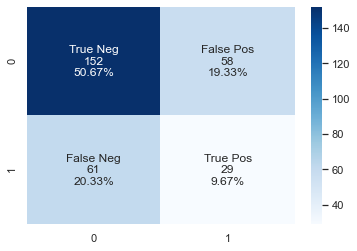

In [ ]:
dTree_train_results = model_performance_classification(dTree, X_train, y_train)
dTree_test_results = model_performance_classification(dTree, X_test, y_test)
dTreeResults = pd.concat([dTree_train_results, dTree_test_results], ignore_index=True).rename(index={0: 'Train', 1: 'Test'})
print('Decision Tree Results \n', dTreeResults, '\n')
make_confusion_matrix(dTree, X_test, y_test)

**Observation**

> The performance of the Decision Tree reveals that the trained model is drastically overfitting the training data.



---

#### ***Random Forest Estimator***

In [ ]:
rf_estimator = RandomForestClassifier(random_state=42)
rf_estimator.fit(X_train,y_train);

Random Forest Results 
        Accuracy    Recall  Precision        F1
Train  1.000000  1.000000   1.000000  1.000000
Test   0.693333  0.255556   0.479167  0.333333 



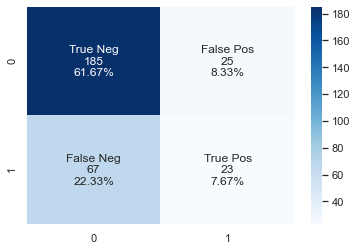

In [ ]:
rf_train_results = model_performance_classification(rf_estimator, X_train, y_train)
rf_test_results = model_performance_classification(rf_estimator, X_test, y_test)
rfResults = pd.concat([rf_train_results, rf_test_results], ignore_index=True).rename(index={0: 'Train', 1: 'Test'})
print('Random Forest Results \n', rfResults, '\n')
make_confusion_matrix(rf_estimator, X_test, y_test)

**Observation**

> Likewise, the performance of the Random Forest Estimator reveals that the trained model is drastically overfitting the training data as well.



---

#### ***Comparison***

In [ ]:
train_models_comp_df = pd.concat(
    [dTree_train_results.T, rf_train_results.T,],
    axis=1,
)
train_models_comp_df.columns = ["DTree Train", "RF Train"]
print("Performance Comparison: Train")
train_models_comp_df

Performance Comparison: Train


,DTree Train,RF Train
Accuracy,1.0,1.0
Recall,1.0,1.0
Precision,1.0,1.0
F1,1.0,1.0


**Observation**

> Both the Decision Tree and Random Forest Estimator overfitted the training set


---

In [ ]:
test_models_comp_df = pd.concat(
    [dTree_test_results.T,rf_test_results.T],
    axis=1,
)
test_models_comp_df.columns = ["DTree Test","RF Test"]
print("Performance Comparison: Test")
test_models_comp_df

Performance Comparison: Test


,DTree Test,RF Test
Accuracy,0.603333,0.693333
Recall,0.322222,0.255556
Precision,0.333333,0.479167
F1,0.327684,0.333333


**Observation**

> Despite overfitting the training data, the Random Forest Estimator slightly performed better than the Decision Tree in the Accuracy, Precision and F1-Score metrics.


---

## ***Tuning and Evaluation***
* Improved the performance of the models by tuning the hyperparameters using GridSeachCV
* Compared the performance of all four models (pre and post tuned) 
* Based on the Recall metric, the best model was selected

**Comment**

> *In order to balance out the number of false positive (those who are classified as risky but are NOT risky) and false negatives (those who are classified as NOT risky but are risky), the F1-Score metric will be used to evaluate the tuned models to improve performance. This will tamper any lost revenue from granting loans to applicants who are risky AND forfeiting revenue from denying loans to applicants who are NOT risky.*

---

#### ***Decision Tree Tuned***

In [ ]:
#Choose the type of classifier. 
dtree_base = DecisionTreeClassifier(random_state=42)

# Grid of parameters to choose from
weights = [{0: .3,1: .7}]

parameters = {'max_depth': list(np.arange(2, 8, 1)), 
              'min_samples_leaf': [5, 10, 15, 20, 25],
              'max_leaf_nodes' : [3, 5, 10, 15],
              'min_impurity_decrease': [0.001, 0.01, 0.1],
              'class_weight': weights
              }

# Type of scoring used to compare parameter combinations
scorer = make_scorer(f1_score)

# Run the grid search or run random search
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
grid_obj = GridSearchCV(dtree_base, parameters, scoring=scorer, cv=cv, n_jobs=-1)
#rand_obj = RandomizedSearchCV(dtree_base, parameters, scoring=scorer, cv=cv, n_jobs=-1, random_state=42)

%time grid_obj = grid_obj.fit(X_train, y_train)
#%time rand_obj = rand_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dtree_tuned = grid_obj.best_estimator_
#dtree_tuned = rand_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_tuned.fit(X_train, y_train)

CPU times: user 24.4 s, sys: 509 ms, total: 24.9 s
Wall time: 38.5 s


DecisionTreeClassifier(class_weight={0: 0.3, 1: 0.7}, max_depth=7,
                       max_leaf_nodes=10, min_impurity_decrease=0.001,
                       min_samples_leaf=10, random_state=42)

Decision Tree Tuned Results 
        Accuracy    Recall  Precision        F1
Train  0.667143  0.695238   0.463492  0.556190
Test   0.580000  0.588889   0.373239  0.456897 



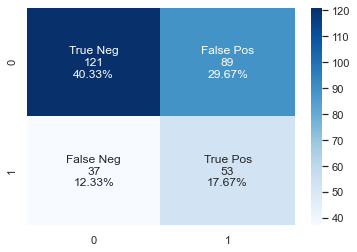

In [ ]:
dTreeTuned_train_results = model_performance_classification(dtree_tuned, X_train, y_train)
dTreeTuned_test_results = model_performance_classification(dtree_tuned, X_test, y_test)
dTreeTunedResults = pd.concat([dTreeTuned_train_results, dTreeTuned_test_results], ignore_index=True).rename(index={0: 'Train', 1: 'Test'})
print('Decision Tree Tuned Results \n', dTreeTunedResults, '\n')
make_confusion_matrix(dtree_tuned, X_test, y_test)

**Observation**

> Although the tuned model did not overfit the training data, the performance is low. With a precision of 37%, recall of 59% and f1-score of .456, the performance metrics leave much to be desired.

---

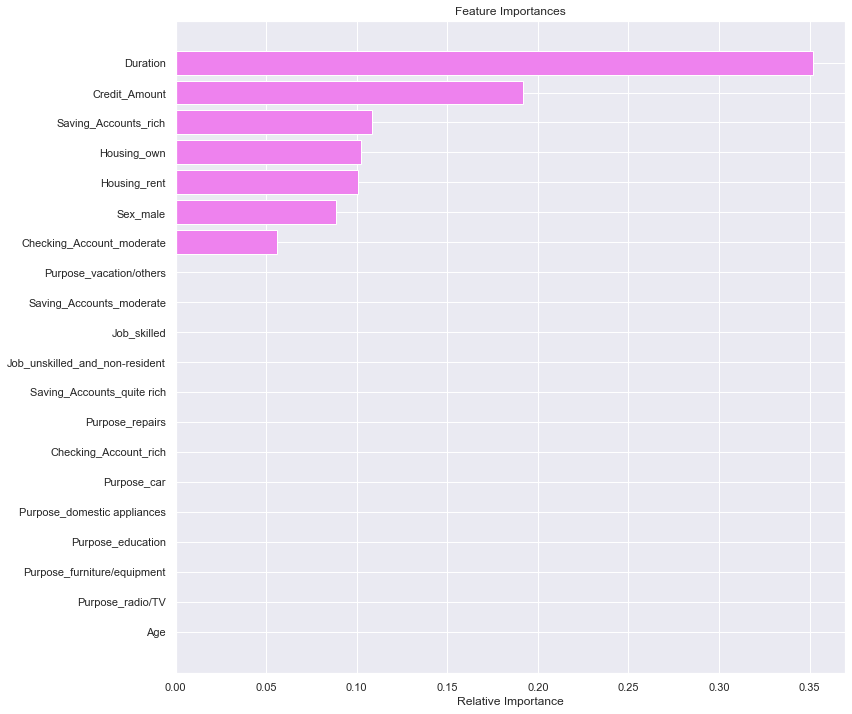

In [ ]:
importances = dtree_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [ ]:
#plt.figure(figsize=(20, 30))
#tree.plot_tree(dtree_tuned, feature_names=feature_names, filled=True, fontsize=9, node_ids=True, class_names=True,);
# Text report showing the rules of a decision tree -
print(tree.export_text(dtree_tuned, feature_names=feature_names, show_weights=True))

|--- Duration <= 16.50
|   |--- Credit_Amount <= 959.50
|   |   |--- Duration <= 8.50
|   |   |   |--- weights: [6.60, 2.10] class: 0
|   |   |--- Duration >  8.50
|   |   |   |--- weights: [7.50, 16.10] class: 1
|   |--- Credit_Amount >  959.50
|   |   |--- Housing_own <= 0.50
|   |   |   |--- weights: [15.60, 14.00] class: 0
|   |   |--- Housing_own >  0.50
|   |   |   |--- Credit_Amount <= 4280.00
|   |   |   |   |--- weights: [42.00, 9.80] class: 0
|   |   |   |--- Credit_Amount >  4280.00
|   |   |   |   |--- weights: [1.80, 2.80] class: 1
|--- Duration >  16.50
|   |--- Saving_Accounts_rich <= 0.50
|   |   |--- Housing_rent <= 0.50
|   |   |   |--- Checking_Account_moderate <= 0.50
|   |   |   |   |--- weights: [29.70, 48.30] class: 1
|   |   |   |--- Checking_Account_moderate >  0.50
|   |   |   |   |--- Sex_male <= 0.50
|   |   |   |   |   |--- weights: [4.80, 11.20] class: 1
|   |   |   |   |--- Sex_male >  0.50
|   |   |   |   |   |--- weights: [27.00, 18.20] class: 0
|   |  

*Observation**

> The tuned decision tree had a feature importance skewed heavily towards duration and credit amounts followed by categorical features such as "rich" saving accounts and owning a home or renting.

> For example, an applicants who own a house and seeking a credit loan greater than 4280 but the duration is less than 16.5 months, that applicant is labeled as being a risk. Applicants seeking a small loan below 959 but require more than 8.5 months to repay, those applicants are also considered risky.


---

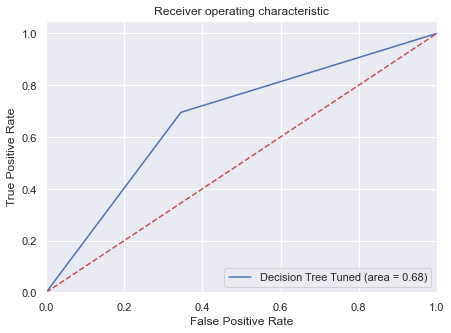

In [ ]:
dTreeTuned_roc_auc_train = roc_auc_score(y_train, dtree_tuned.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, dtree_tuned.predict(X_train))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Decision Tree Tuned (area = %0.2f)" % dTreeTuned_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

**Observation**

> The tuned decision tree performance is better than random guessing.

---

#### ***Random Forest Estimator Tuned***

In [ ]:
#Choose the type of classifier. 
rf_estimator_base = RandomForestClassifier(random_state=42) # using reverse class weights

# Grid of parameters to choose from
weights = [{0: .3,1: .7}]

parameters = {  
                'max_depth': list(np.arange(2, 8, 1)), 
                'max_features': list(np.arange(0.5,0.8,0.1)),
                'max_samples': list(np.arange(0.8,1,0.1)),
                'min_samples_split': list(np.arange(1, 15, 5)),
                'n_estimators': list(np.arange(20,200,40)),
                'min_impurity_decrease': [0.001,0.01,0.1],
                'class_weight': weights
              }

# Type of scoring used to compare parameter combinations
scorer = make_scorer(f1_score)

# Run the grid search or run random search
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
grid_obj = GridSearchCV(rf_estimator_base, parameters, scoring=scorer, cv=cv, n_jobs=-1)
#rand_obj = RandomizedSearchCV(rf_estimator_base, parameters, scoring=scorer, cv=cv, n_jobs=-1, random_state=42)

%time grid_obj = grid_obj.fit(X_train, y_train)
#%time rand_obj = rand_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_
#rf_estimator_tuned = rand_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_estimator_tuned.fit(X_test, y_test)

CPU times: user 15min 2s, sys: 35.3 s, total: 15min 37s
Wall time: 1h 54min 9s


RandomForestClassifier(class_weight={0: 0.3, 1: 0.7}, max_depth=2,
                       max_features=0.6, max_samples=0.9,
                       min_impurity_decrease=0.001, min_samples_split=6,
                       n_estimators=20, random_state=42)

Random Forest Tuned Results 
        Accuracy    Recall  Precision        F1
Train  0.652857  0.395238   0.417085  0.405868
Test   0.713333  0.500000   0.523256  0.511364 



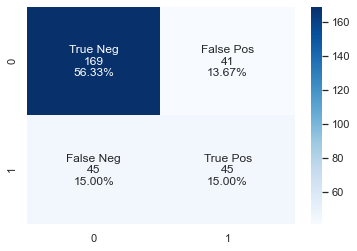

In [ ]:
rfTuned_train_results = model_performance_classification(rf_estimator_tuned, X_train, y_train)
rfTuned_test_results = model_performance_classification(rf_estimator_tuned, X_test, y_test)
rfTunedResults = pd.concat([rfTuned_train_results, rfTuned_test_results], ignore_index=True).rename(index={0: 'Train', 1: 'Test'})
print('Random Forest Tuned Results \n', rfTunedResults, '\n')
make_confusion_matrix(rf_estimator_tuned, X_test, y_test)

**Observation**

> Although the tuned random forest estimator model did not overfit the training data, the performance is also low but better than the tuned decision tree. With a precision of 52%, recall of 50% and f1-score of .511, the performance metrics slightly outperform the tuned decision tree.

---

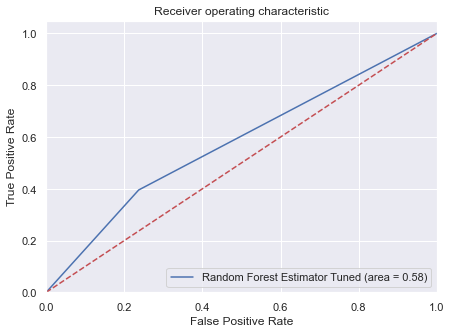

In [ ]:
rfTuned_roc_auc_train = roc_auc_score(y_train, rf_estimator_tuned.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, rf_estimator_tuned.predict(X_train))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Random Forest Estimator Tuned (area = %0.2f)" % rfTuned_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

**Observation**

> The tuned random forest estimator performance is better than random guessing.

---

#### ***Comparison: Untuned and Tuned***

In [ ]:
models_train_comp_df = pd.concat(
    [dTree_train_results.T, dTreeTuned_train_results.T,
     rf_train_results.T,rfTuned_train_results.T],
    axis=1,
)
models_train_comp_df.columns = ["DTree", "DTreeTuned", "RF","RFTuned"]
print("Train Performance Comparison")
models_train_comp_df

Train Performance Comparison


,DTree,DTreeTuned,RF,RFTuned
Accuracy,1.0,0.667143,1.0,0.652857
Recall,1.0,0.695238,1.0,0.395238
Precision,1.0,0.463492,1.0,0.417085
F1,1.0,0.556190,1.0,0.405868


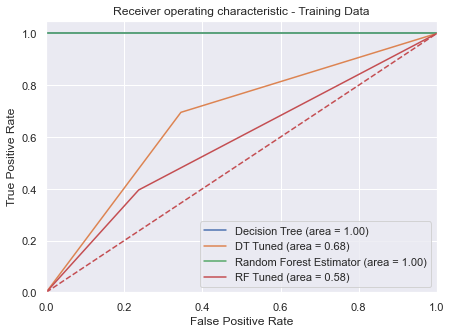

In [ ]:
plt.figure(figsize=(7, 5))

dTree_roc_auc_train = roc_auc_score(y_train, dTree.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, dTree.predict(X_train))

plt.plot(fpr, tpr, label="Decision Tree (area = %0.2f)" % dTree_roc_auc_train)

dTreeTuned_roc_auc_train = roc_auc_score(y_train, dtree_tuned.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, dtree_tuned.predict(X_train))

plt.plot(fpr, tpr, label="DT Tuned (area = %0.2f)" % dTreeTuned_roc_auc_train)

rf_roc_auc_train = roc_auc_score(y_train, rf_estimator.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, rf_estimator.predict(X_train))

plt.plot(fpr, tpr, label="Random Forest Estimator (area = %0.2f)" % rf_roc_auc_train)

rfTuned_roc_auc_train = roc_auc_score(y_train, rf_estimator_tuned.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, rf_estimator_tuned.predict(X_train))

plt.plot(fpr, tpr, label="RF Tuned (area = %0.2f)" % rfTuned_roc_auc_train)

plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic - Training Data")
plt.legend(loc="lower right")
plt.show()

**Observation**

> Both the Decision Tree and Random Forest Estimator tuned models fit the training data better than the untuned models. At first glance, it appears that the decision tree tuned model has higher metrics than the tuned random forest estimator.


---

In [ ]:
models_test_comp_df = pd.concat(
    [dTree_test_results.T, dTreeTuned_test_results.T,
     rf_test_results.T,rfTuned_test_results.T],
    axis=1,
)
models_test_comp_df.columns = ["DTree", "DTreeTuned", "RF","RFTuned"]
print("Test Performance Comparison")
models_test_comp_df

Test Performance Comparison


,DTree,DTreeTuned,RF,RFTuned
Accuracy,0.603333,0.580000,0.693333,0.713333
Recall,0.322222,0.588889,0.255556,0.500000
Precision,0.333333,0.373239,0.479167,0.523256
F1,0.327684,0.456897,0.333333,0.511364


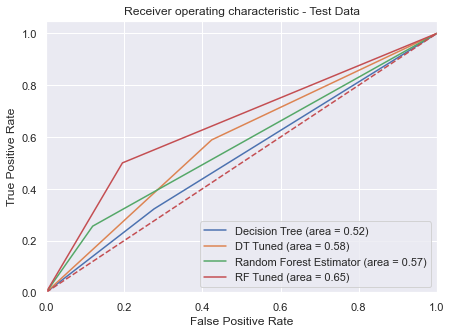

In [ ]:
plt.figure(figsize=(7, 5))

dTree_roc_auc_train = roc_auc_score(y_test, dTree.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dTree.predict(X_test))

plt.plot(fpr, tpr, label="Decision Tree (area = %0.2f)" % dTree_roc_auc_train)

dTreeTuned_roc_auc_train = roc_auc_score(y_test, dtree_tuned.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dtree_tuned.predict(X_test))

plt.plot(fpr, tpr, label="DT Tuned (area = %0.2f)" % dTreeTuned_roc_auc_train)

rf_roc_auc_train = roc_auc_score(y_test, rf_estimator.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_estimator.predict(X_test))

plt.plot(fpr, tpr, label="Random Forest Estimator (area = %0.2f)" % rf_roc_auc_train)

rfTuned_roc_auc_train = roc_auc_score(y_test, rf_estimator_tuned.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_estimator_tuned.predict(X_test))

plt.plot(fpr, tpr, label="RF Tuned (area = %0.2f)" % rfTuned_roc_auc_train)

plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic - Test Data")
plt.legend(loc="lower right")
plt.show()

**Observation**

> Both the Decision Tree and Random Forest Estimator tuned models performed better than their untuned counter parts. The tuned random forest estimator had the better metrics compared to all four models. Both the ROC curve and f1-score metrics provide evidences such performance.


---

## ***Insights***
* Determined the feature importance in the chosen model
* Described the business insights


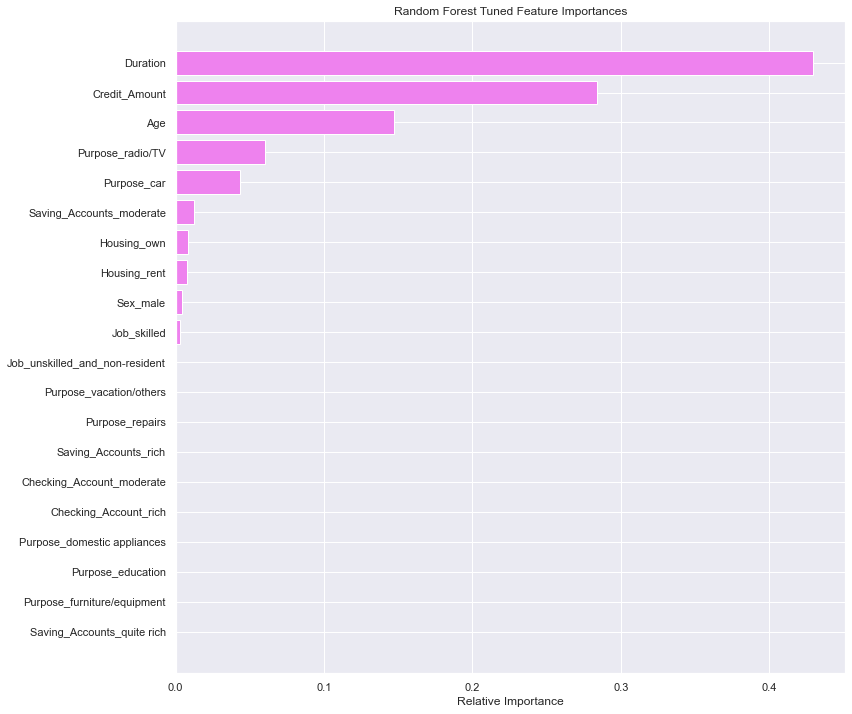

In [ ]:
importances = rf_estimator_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Random Forest Tuned Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

*Conclusion**

> The tuned random forest estimator had a feature importance skewed heavily towards duration, credit amounts and age followed by categorical features such as applying for a loan for a tv/radio or car, a "moderate" saving accounts and owning a home or renting.

> The continuous variable features **duration**, **age** and **credit amounts** have the highest influence on if an applicant is considered a risk or not.  



---